# Imperfect Semantic Segmentation

In the real world, we won't have a perfect SS as a input to our model. Thus, it makes sense to try, a priori, a model trained with corrupted semantic segmentation images. This is a way to do this.

In [1]:
import cv2
import numpy as np

def apply_boundary_blur(image_path, blur_radius, save=False):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect edges using Canny
    edges = cv2.Canny(gray, 100, 200)
    
    # Dilate the edge lines to make the boundaries thicker
    dilation_kernel = np.ones((3,3), np.uint8)
    edges_dilated = cv2.dilate(edges, dilation_kernel, iterations=1)
    
    # Create a mask where the edges are
    mask = edges_dilated > 0
    
    # Apply Gaussian blur to the original image
    blurred = cv2.GaussianBlur(image, (blur_radius, blur_radius), 0)
    
    # Combine the original and blurred images using the mask
    image[mask] = blurred[mask]
    
    # Save the result
    if save:
        output_path = 'corrupted_' + image_path.split('/')[-1]
        cv2.imwrite(output_path, image)

        return image, output_path
    return image

In [12]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=15)

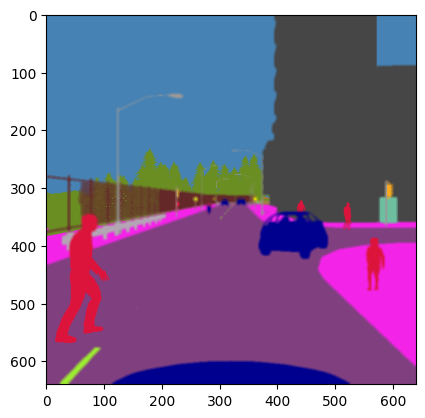

In [13]:
import matplotlib.pyplot as plt

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
# Let's make a grid of plots for different kernel sizes of the 
# Gaussian blur
import scipy.ndimage

sigmas = [0, 1, 5, 10, 20, 50, 100]

def blur_image(img, sigma=1):
    return scipy.ndimage.gaussian_filter(img, sigma=sigma)

for sigma in sigmas:
    blurred = blur_image(stack, sigma=sigma)
    plt.figure(figsize=(15, 5))
    plt.imshow(blurred, cmap='gray')
    plt.axes().set_xticks([])
    plt.axes().set_yticks([])
    plt.title(f'Sigma = {sigma}')
    plt.show()

In [ ]:
import cv2
import numpy as np

def apply_boundary_blur(image_path, blur_radius, save=False):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Make sure to read the image unchanged (with alpha channel if present)
    
    # Store original shape for later
    original_shape = image.shape
    
    # Flatten the image to 1D array for unique color values (ignoring potential alpha channel)
    flat_image = image.reshape(-1, image.shape[-1])
    unique_colors = np.unique(flat_image, axis=0)
    
    # Create an empty (black) image to draw blurred boundaries
    blurred_boundaries = np.zeros_like(image)
    
    for color in unique_colors:
        # Create a mask for current color
        mask = cv2.inRange(image, color, color)
        
        # Find contours for the current mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw filled contours on the empty image
        cv2.drawContours(blurred_boundaries, contours, -1, color, thickness=cv2.FILLED)
    
    # Apply Gaussian blur to the boundaries image
    blurred_boundaries = cv2.GaussianBlur(blurred_boundaries, (blur_radius, blur_radius), 0)
    
    # Ensure the blurred image has the same number of channels as the original
    if len(original_shape) == 3 and original_shape[2] == 4:
        # Add an alpha channel to the blurred image
        alpha_channel = np.ones((original_shape[0], original_shape[1], 1), dtype=image.dtype) * 255
        blurred_boundaries = np.concatenate((blurred_boundaries, alpha_channel), axis=-1)

    # Iterate through unique colors to threshold and apply each color to the original image
    for color in unique_colors:
        # Threshold the blurred image back to the original color
        mask = cv2.inRange(blurred_boundaries, color, color)
        
        # Apply the thresholded mask to the original image to restore discrete class labels
        image[mask > 0] = color
    
    # Save the result
    if save:
        output_path = 'blurred_' + image_path.split('/')[-1]
        cv2.imwrite(output_path, image)

        return image, output_path
    return image


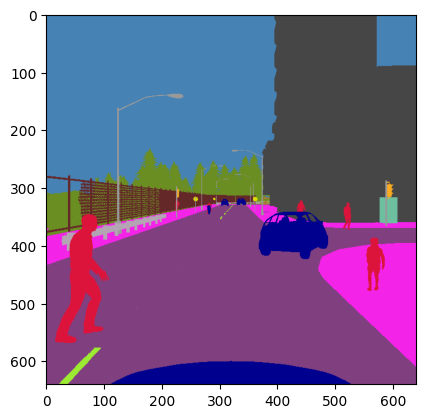

In [28]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=1)

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

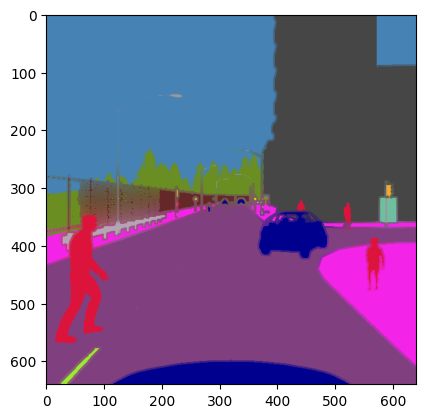

In [31]:
# Set the path to your semantic segmentation image
image_path = 'test_data/attention_t01_route00_clearnoon/ss_central000517.png'

# Apply the boundary blur with the desired radius
image = apply_boundary_blur(image_path, blur_radius=149)

# Let's view the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [1]:
import cv2
import numpy as np

def create_transition_zones(label_image, transition_width):
    """
    Identify boundary pixels and create transition zones between classes.
    """
    # Copy the label image to work on
    transition_image = np.copy(label_image)
    
    # Identify boundaries and dilate them
    edges = cv2.Canny(label_image, 100, 200)
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=transition_width)
    
    # Set the boundary pixels to a special value indicating a transition zone
    transition_image[dilated_edges > 0] = -1  # Assuming no class label is -1
    
    return transition_image

def reassign_transition_labels(transition_image, original_labels):
    """
    Reassign the transition pixels to valid class labels.
    """
    # Identify pixels in the transition zones
    transition_pixels = np.where(transition_image == -1)
    
    for pixel in zip(transition_pixels[0], transition_pixels[1]):
        # Get the neighborhood of the pixel
        neighborhood = transition_image[pixel[0]-1:pixel[0]+2, pixel[1]-1:pixel[1]+2]
        
        # Find the most common label in the neighborhood
        unique, counts = np.unique(neighborhood, return_counts=True)
        most_common_label = unique[np.argmax(counts)]
        
        # Reassign the pixel to the most common label
        transition_image[pixel] = most_common_label
    
    return transition_image



In [13]:
depth_paths = ['test_data/attention_t01_route00_clearnoon/depth_central000517.png']
semantic_segmentation_paths = ['test_data/attention_t01_route00_clearnoon/ss_central000517.png']


In [14]:
from dataloaders import transforms

*_, mask_merge_central = transforms.get_virtual_attention_map(
        depth_path=depth_paths[0],
        segmented_path=semantic_segmentation_paths[0],
        depth_threshold=20.0,
        min_depth=2.3,
        central_camera=True
    )

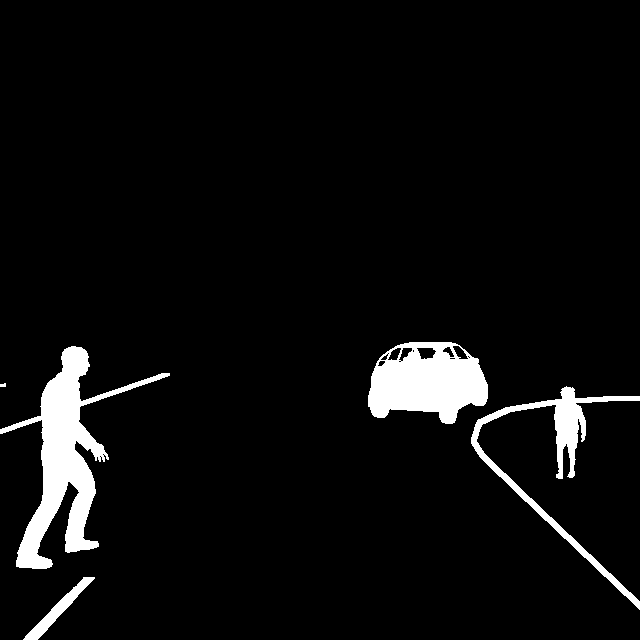

In [16]:
from PIL import Image

Image.fromarray(mask_merge_central)

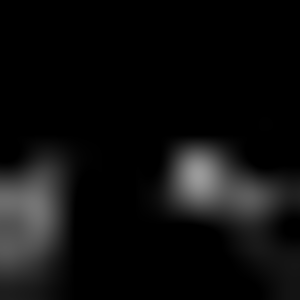

In [17]:
resized_mask_merge_central = cv2.resize(mask_merge_central, (10, 10), interpolation=cv2.INTER_AREA)
resized_mask_merge_central = cv2.resize(resized_mask_merge_central, (300, 300), interpolation=cv2.INTER_CUBIC)

Image.fromarray(resized_mask_merge_central)

In [1]:
og_ss_img = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)
ss_img = cv2.resize(og_ss_img, (10, 10), interpolation=cv2.INTER_CUBIC)
ss_img = cv2.resize(ss_img, (300, 300), interpolation=cv2.INTER_CUBIC)
# ss_img = cv2.cvtColor(ss_img, cv2.COLOR_BGR2RGB)

Image.fromarray(ss_img)

NameError: name 'cv2' is not defined

In [55]:
# Get the original classes (specific RGB values in the image)
original_classes = np.unique(og_ss_img.reshape(-1, og_ss_img.shape[-1]), axis=0)

# For every pixel in the resized semantic segmentation image,
# find the class in the original image that is closest in RGB space
# and assign that class to the pixel. Note the image has 3 channels!
resized_ss_img = np.zeros_like(ss_img)
for i in range(resized_ss_img.shape[0]):
    for j in range(resized_ss_img.shape[1]):
        pixel = ss_img[i, j][None, :]
        distances = np.linalg.norm(original_classes - pixel, axis=1)
        closest_class = original_classes[np.argmin(distances)]
        resized_ss_img[i, j] = closest_class

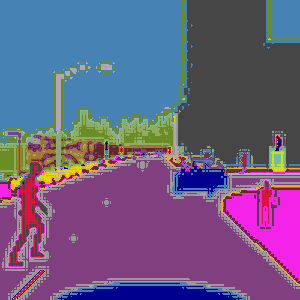

In [56]:
resized_ss_img = cv2.cvtColor(resized_ss_img, cv2.COLOR_BGR2RGB)

Image.fromarray(resized_ss_img)

In [65]:
depth_rgb, segmentation = transforms.read_images(depth_paths[0], semantic_segmentation_paths[0])
depth_img = transforms.process_depth_image(depth_rgb)

*_, imperfect_masks = transforms.create_masks(
    depth_img=depth_img,
    segmentation=segmentation,
    depth_threshold=20.0,
    min_depth=2.3,
    central_camera=True,
    converter=transforms.SS_CONVERTER
)

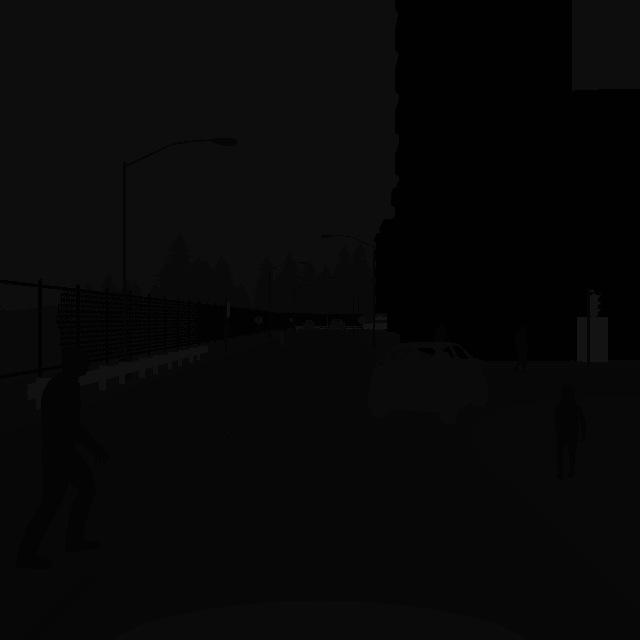

In [71]:
Image.fromarray(segmentation)

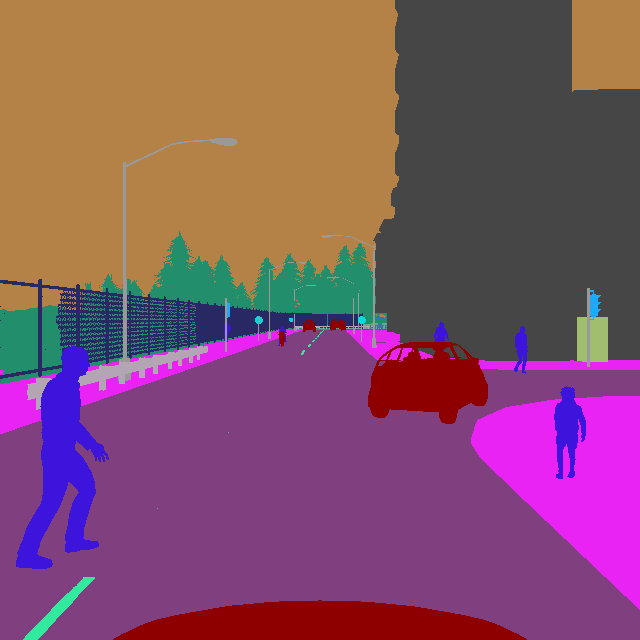

In [69]:
segmented_img = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)

Image.fromarray(segmented_img)

## Voronoi Semantic Segmentation

Another idea is to uniformly sample $N$ points from the image, see their actual class from the original semantic segmentation image, then do a Voronoi tesselation. This way, we corrupt the SS images and obtain a more "standard" semantic segmentation. 

In [5]:
import numpy as np
import cv2
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

depth_paths = ['test_data/attention_t01_route00_clearnoon/depth_central000517.png']
semantic_segmentation_paths = ['test_data/attention_t01_route00_clearnoon/ss_central000517.png']

In [6]:
# First, a simple function to sample N points from an image. To do this, we
# flatten the image to 1D, sample N random indices, and then convert the
# indices back to 2D coordinates.

def sample_points(img, N, random_seed: int = 0):
    # Set random seed
    np.random.seed(random_seed)
    # TODO: how we do this sampling will affect the final distribution; 
    # measure this with e.g. FID?
    
    # Flatten the image to 1D array
    flat_img = img.reshape(-1, img.shape[-1])
    
    # Sample N random indices
    indices = np.random.choice(flat_img.shape[0], N)
    
    # Convert indices back to 2D coordinates
    points = np.array(np.unravel_index(indices, img.shape[:2])).T
    
    return points

# Now, for each point, we want to save its class label, which is the RGB
# value in the semantic segmentation image. We can do this by indexing the
# image with the points.

def get_labels(img, points):
    # Turn img to RGB if it's not already
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    # Index the image with the points to get the labels
    labels = img[points[:, 0], points[:, 1]]
    
    return labels  # If img is RGBA, labels will be Nx4; otherwise, Nx3

# Now, we can use the Voronoi algorithm to create a Voronoi diagram from
# the points. This will create a polygon for each point, where the polygon
# contains all the points that are closest to that point than to any other
# point.

def create_voronoi(points, labels, img_shape):
    # Create a Voronoi diagram from the points
    vor = Voronoi(points)
    
    # Create an empty image with 3 color channels assuming img is RGB(A)
    img_voronoi = np.zeros((img_shape[0], img_shape[1], 3), dtype=np.uint8)
    
    # Iterate over each input point
    for point, label in zip(points, labels):
        # Get the region corresponding to the input point
        region_index = vor.point_region[np.where((points == point).all(axis=1))[0][0]]
        region = vor.regions[region_index]

        # Skip if the region is invalid
        if -1 in region or not region:
            continue

        # Get the RGB values, ignore A if present and ensure the color is a tuple of integers
        color = tuple(map(int, label[:3])) 

        # Create the region polygon
        polygon = vor.vertices[region]

        # Fill the region with the label of its generating point
        cv2.fillPoly(img_voronoi, [polygon.astype(np.int32)], color=color)

    img_voronoi = np.rot90(img_voronoi, k=1)
    img_voronoi = np.flipud(img_voronoi)

    return img_voronoi


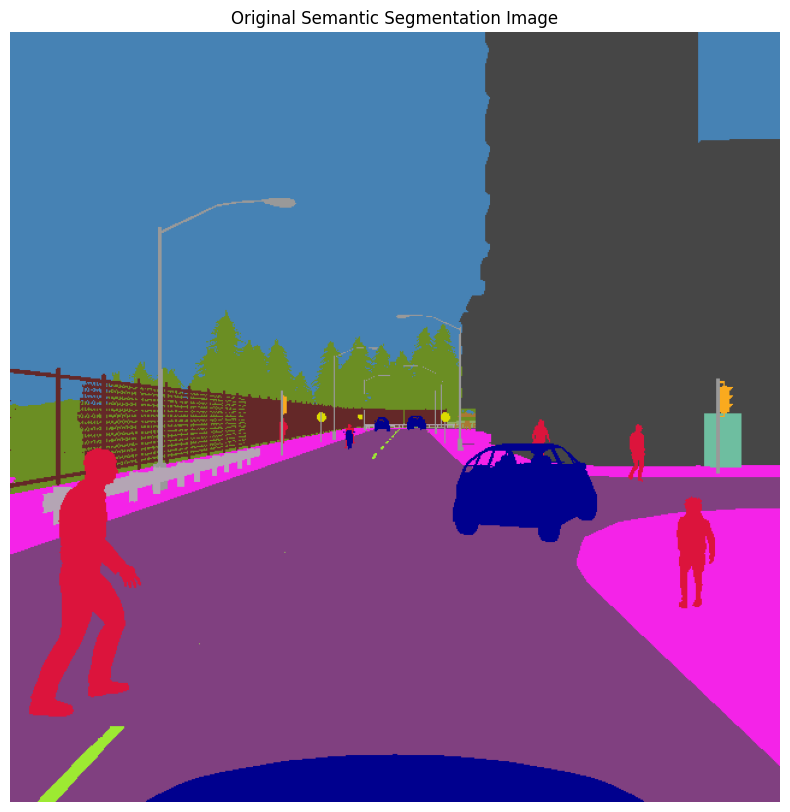

In [10]:
# Test this with the semantic segmentation image
s = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)
s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

# np.random.seed(42)
# points = sample_points(s, 100)

# Plot the points on top of the image
plt.figure(figsize=(10, 10))
plt.imshow(s)
plt.axis('off')
plt.title('Original Semantic Segmentation Image')
plt.show()

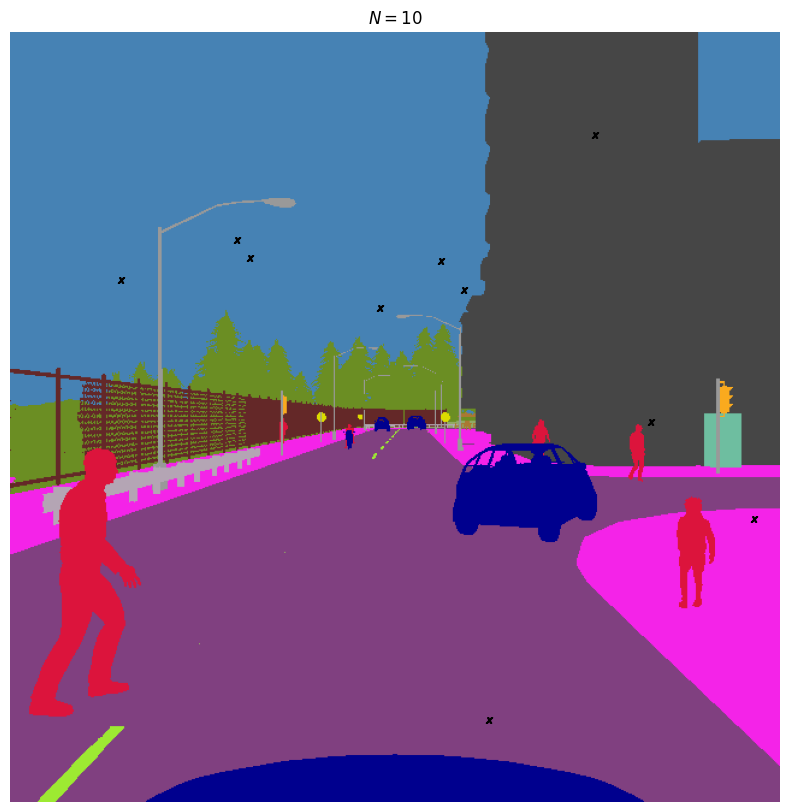

In [11]:
# Test this with the semantic segmentation image
s = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)
s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

points = sample_points(s, 10, random_seed=42)

# Plot the points on top of the image
plt.figure(figsize=(10, 10))
plt.imshow(s)
plt.scatter(points[:, 1], points[:, 0], s=20, c='black', marker='$x$')
plt.title(f'$N={points.shape[0]}$')
plt.axis('off')
plt.show()

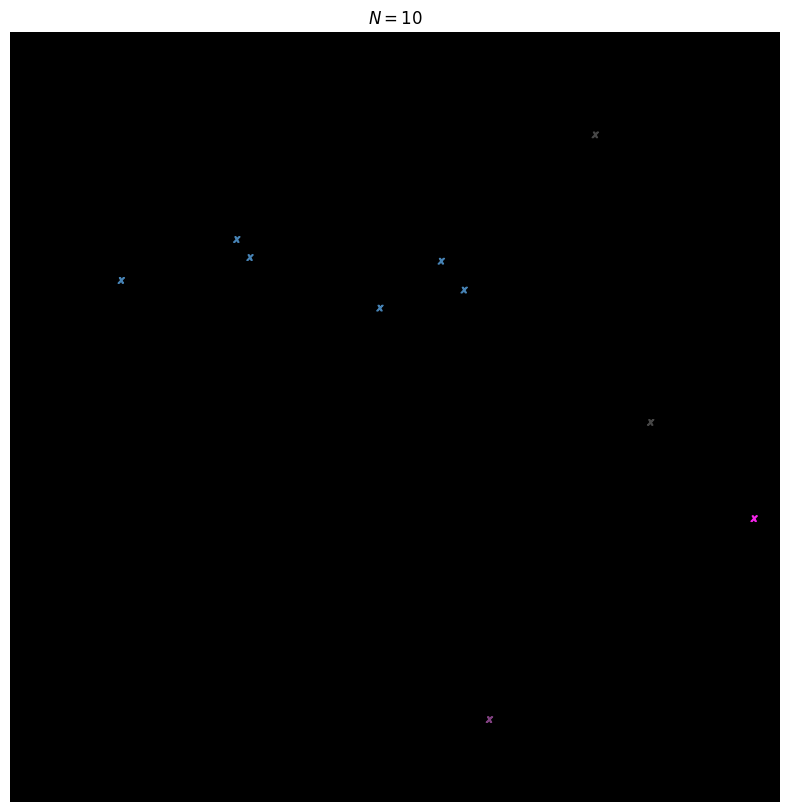

In [14]:
labels = get_labels(s, points)

# Let's plot the points with their labels as their colors (just the RGB values)
# with a colorbar to show the class names. Do this in a black image.

# Create a black image
black_img = np.zeros_like(s[:, :, :3], dtype=np.uint8)

# Plot the points on top of the image
plt.figure(figsize=(10, 10))
plt.imshow(black_img, vmin=0, vmax=255, cmap='gray')
plt.scatter(points[:, 1], points[:, 0], s=20, c=labels/255.0, marker='$x$')
plt.title(f'$N={points.shape[0]}$')
plt.axis('off')
plt.show()

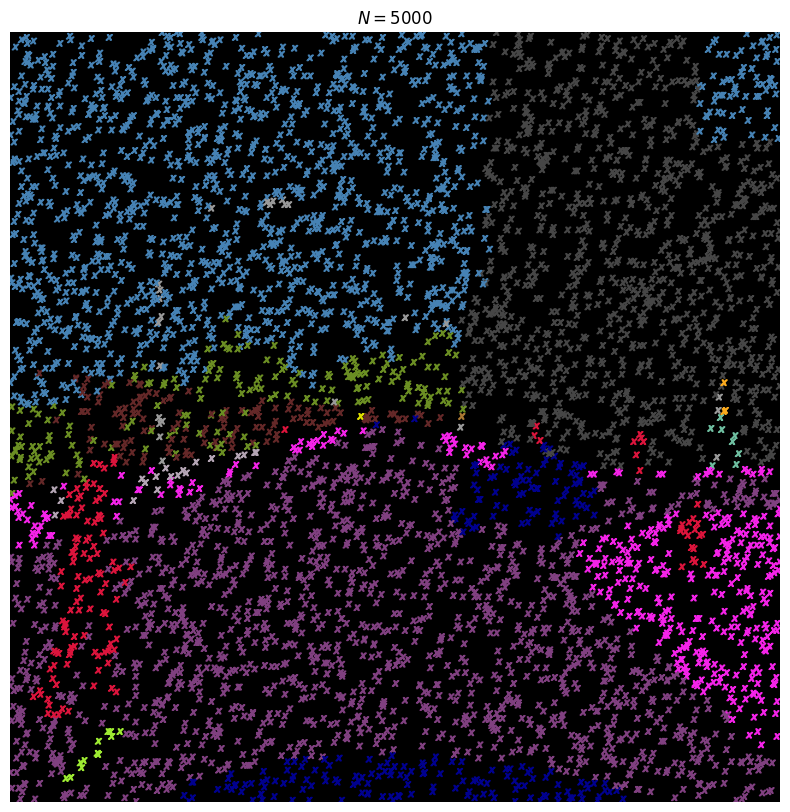

In [138]:
labels = get_labels(segmented_img, points)

# Let's plot the points with their labels as their colors (just the RGB values)
# with a colorbar to show the class names. Do this in a black image.

# Create a black image
black_img = np.zeros_like(segmented_img[:, :, :3], dtype=np.uint8)

# Plot the points on top of the image
plt.figure(figsize=(10, 10))
plt.imshow(black_img, vmin=0, vmax=255, cmap='gray')
plt.scatter(points[:, 1], points[:, 0], s=20, c=labels/255.0, marker='$x$')
plt.title(f'$N={points.shape[0]}$')
plt.axis('off')
plt.show()

In [10]:
# Test this with the semantic segmentation image
segmented_img = cv2.imread(semantic_segmentation_paths[0], cv2.IMREAD_UNCHANGED)
segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)

In [15]:
list(range(1, 6, 2))

[1, 3, 5]

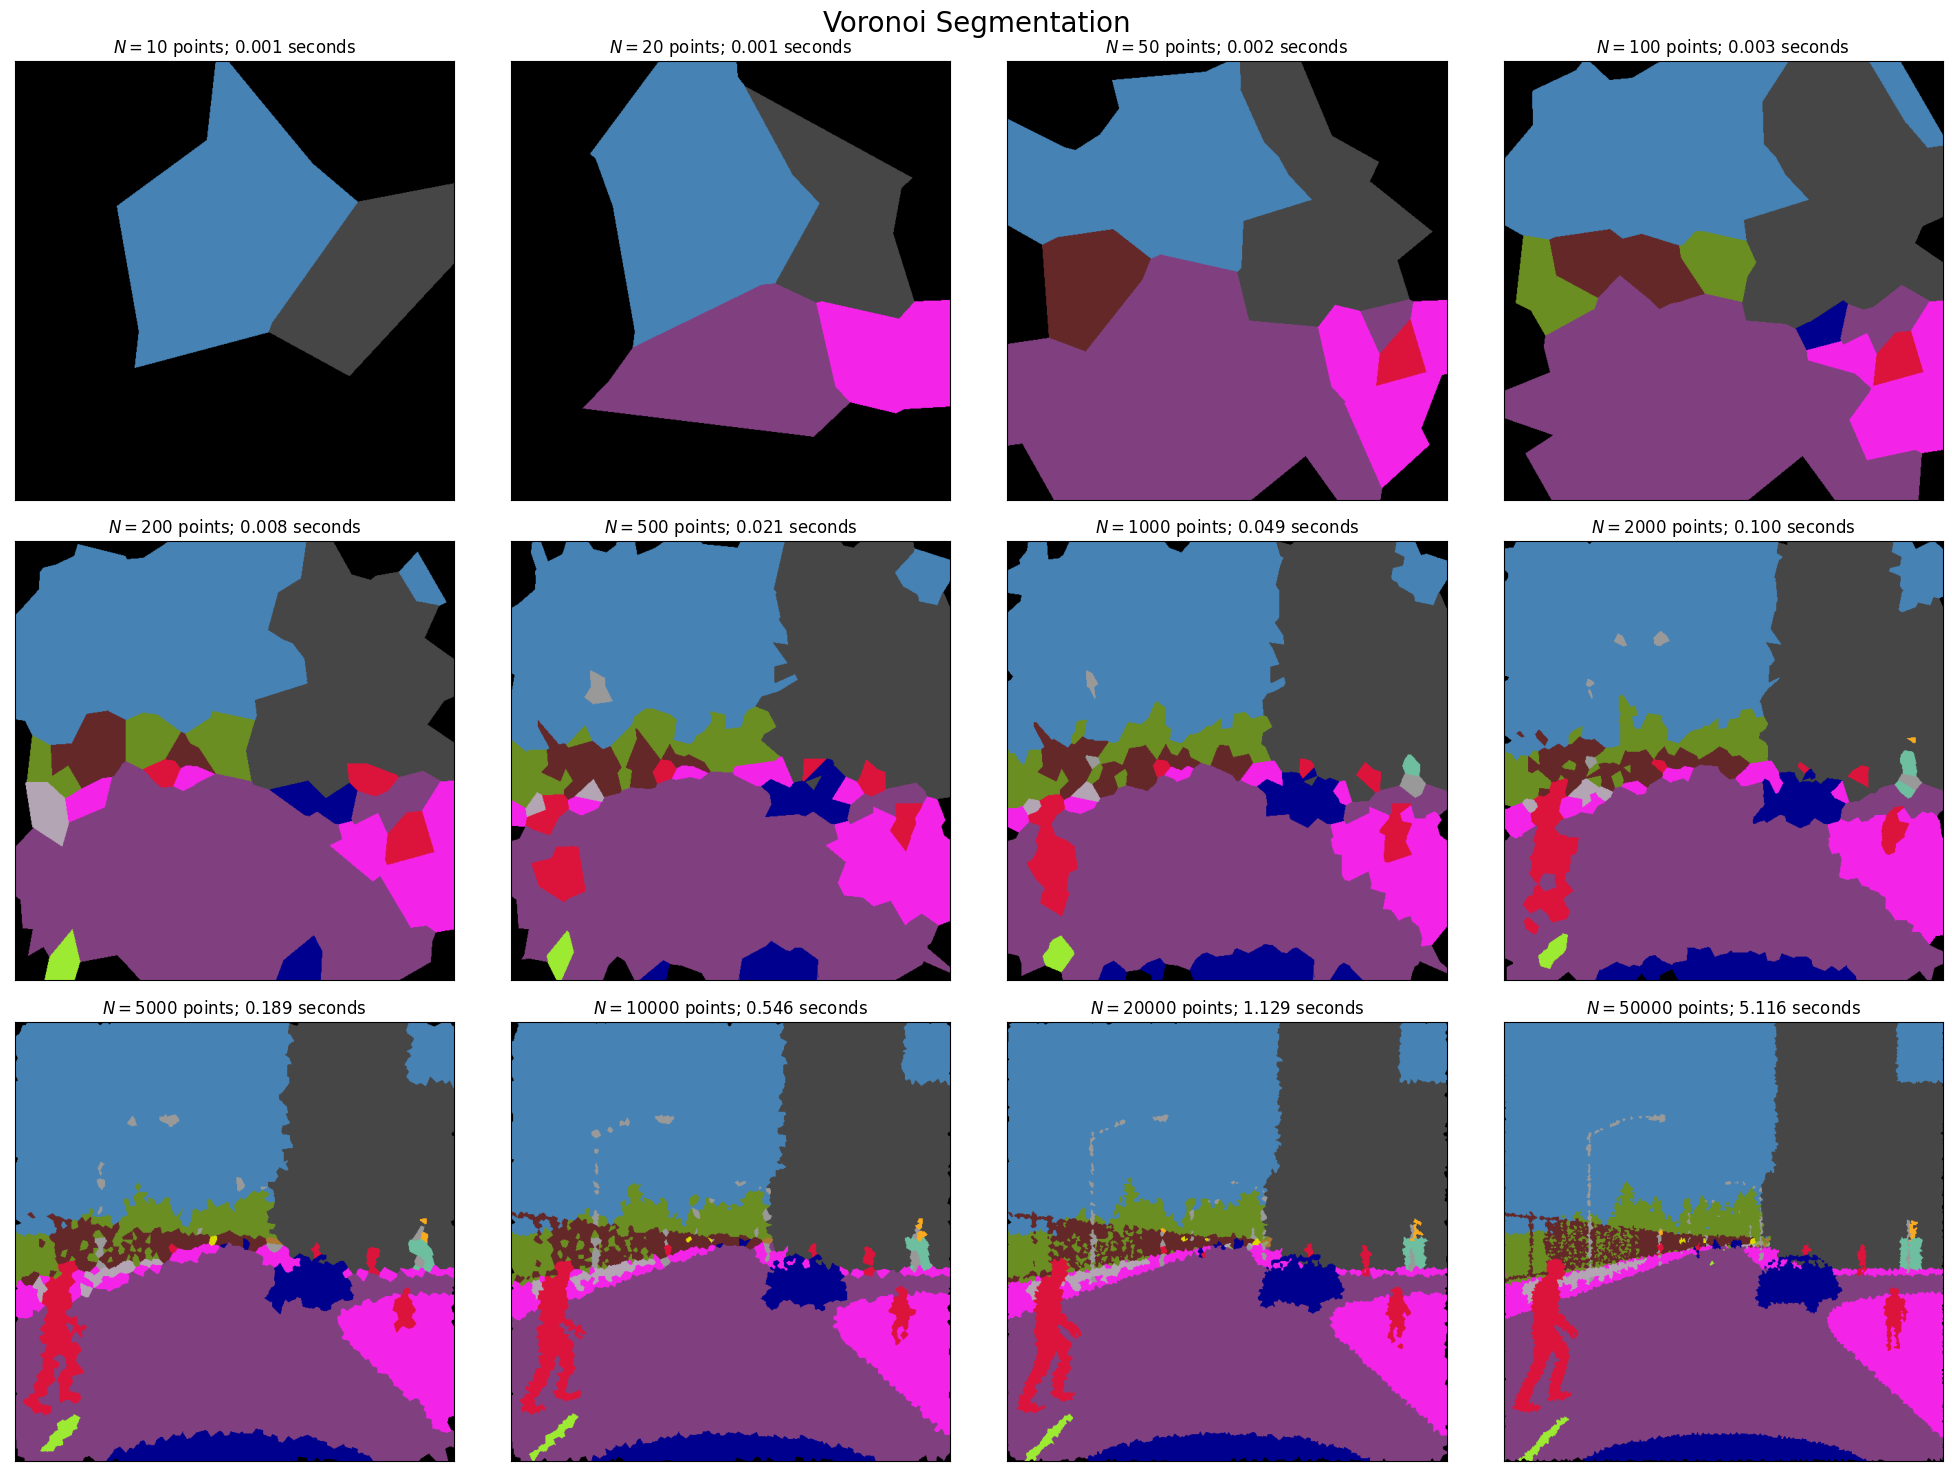

In [16]:
import time

num_points_list = [c*10**n for n in range(1, 5) for c in [1, 2, 5]]
img_shape = (segmented_img.shape[0], segmented_img.shape[1], 3)

# Grid shape
num_cols = max(int(np.ceil(np.sqrt(len(num_points_list)))), 1)   # width of grid
num_rows = max((len(num_points_list) - 1) // num_cols + 1, 1)    # height of grid

# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Iterate over the number of points
for num_points in num_points_list:
    # Time the Voronoi diagram creation
    t = time.time()
    # Sample points from the semantic segmentation image
    points = sample_points(segmented_img, num_points, random_seed=42)

    # Get the labels for the points
    labels = get_labels(segmented_img, points)

    # Create the Voronoi diagram
    voronoi_img = create_voronoi(points, labels, img_shape)
    # voronoi_img = cv2.cvtColor(voronoi_img, cv2.COLOR_BGR2RGB)
    # Get the total time
    t = time.time() - t

    # Plot the Voronoi diagram
    axes.flat[num_points_list.index(num_points)].imshow(voronoi_img)
    
    # plt.imshow(voronoi_img)
    # Plot the points
    # plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5)

    # Set the title and remove ticks
    axes.flat[num_points_list.index(num_points)].set_title(f'$N={num_points}$ points; {t:.3f} seconds')
    axes.flat[num_points_list.index(num_points)].set_xticks([])
    axes.flat[num_points_list.index(num_points)].set_yticks([])
    
    # plt.title(f'Voronoi Segmentation, $N={num_points}$ points; {t:.3f} seconds')
    # plt.axis('off')
fig.suptitle('Voronoi Segmentation', fontsize=20)
plt.tight_layout()
plt.show()

### Get the attention masks for each of these

Fix the max depth at 20 meters, as usual.

In [2]:
from dataloaders import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

depth_paths = ['test_data/attention_t01_route00_clearnoon/depth_central000517.png']
semantic_segmentation_paths = ['test_data/attention_t01_route00_clearnoon/ss_central000517.png']

depth_rgb, segmentation = transforms.read_images(depth_paths[0], 
                                                 semantic_segmentation_paths[0])
depth_img = transforms.process_depth_image(depth_rgb)

num_points_list = [c*10**n for n in range(1, 5) for c in [1, 2, 5]]
img_shape = (segmentation.shape[0], segmentation.shape[1], 3)

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tensorflow/python/framework/dt

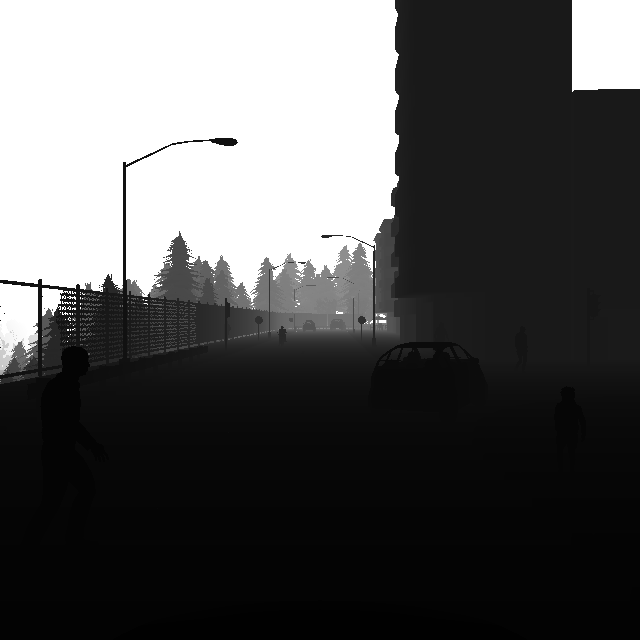

In [4]:
from PIL import Image

Image.fromarray(depth_img).convert('L')

In [ ]:

# Grid shape
num_cols = max(int(np.ceil(np.sqrt(len(num_points_list)))), 1)   # width of grid
num_rows = max((len(num_points_list) - 1) // num_cols + 1, 1)    # height of grid

# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

# Iterate over the number of points
for num_points in num_points_list:
    # Time the Voronoi diagram creation
    t = time.time()
    # Sample points from the semantic segmentation image
    points = sample_points(segmented_img, num_points, random_seed=42)

    # Get the labels for the points
    labels = get_labels(segmented_img, points)

    # Create the Voronoi diagram
    voronoi_img = create_voronoi(points, labels, img_shape)
    # voronoi_img = cv2.cvtColor(voronoi_img, cv2.COLOR_BGR2RGB)
    # Get the total time
    t = time.time() - t

    # Plot the Voronoi diagram
    axes.flat[num_points_list.index(num_points)].imshow(voronoi_img)
    
    # plt.imshow(voronoi_img)
    # Plot the points
    # plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5)

    # Set the title and remove ticks
    axes.flat[num_points_list.index(num_points)].set_title(f'$N={num_points}$ points; {t:.3f} seconds')
    axes.flat[num_points_list.index(num_points)].set_xticks([])
    axes.flat[num_points_list.index(num_points)].set_yticks([])
    
    # plt.title(f'Voronoi Segmentation, $N={num_points}$ points; {t:.3f} seconds')
    # plt.axis('off')
fig.suptitle('Voronoi Segmentation', fontsize=20)
plt.tight_layout()
plt.show()


*_, mask_merge_central = transforms.get_virtual_attention_map(
        depth_path=depth_paths[0],
        segmented_path=semantic_segmentation_paths[0],
        depth_threshold=20.0,
        min_depth=2.3,
        central_camera=True
    )